# Анализ и фильтрация злонамеренного сетевого трафика

## Содержание

**[1. Обзор данных](#1)**

- **[1.1 Ввод необходимых функций](#1.1)**
- **[1.2 Разведочный анализ данных](#1.2)**
- **[1.3. Проверка данных на мультиколлинеарность](#1.3)**
- **[1.4. Проверка данных на бесконечность](#1.4)**
- **[1.5 Общие выводы по качеству имеющихся данных](#1.5)**


**[2. Подготовка данных](#2)**

- **[2.1. Предобработка данных](#2.1)**
- **[2.2. Общие выводы по подготовке данных ](#2.2)**


**[3. Обучение моделей](#3)**

- **[3.1. Общие выводы](#3.1)**


Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика. 

**Цель.** Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

**Цель исследования.** Разработка модели, которая достигнет наилучшего значения по различным метрикам классификации: `precision`, `recall`, `f1_score`, `accuracy`.

**Задачи:**
- загрузить и ознакомится с данными,
- провести предварительную обработку,
- сделать полноценный разведочный анализ,
- разработать новые синтетические признаки,
- проверить на мультиколлинеарность,
- сделать отбор финального набора обучающих признаков,
- выбрать и обучить модели,
- провести итоговую оценку качества предсказания лучшей модели,
- сделать анализ важности признаков модели.

**Входные данные.** Файл в формате `.csv` с различными параметрами входящего трафика (`~540000` строк)

**Формальная задача.** Предсказать значение `label` для входящего трафика по заданным параметрам

**Ожидаемый результат.** Построена модель для детектирования вредоносного трафика, с наилучшим значением метрик классификации: `precision`, `recall`, `f1_score`, `accuracy`.


## Обзор данных <a id='1'></a>

**Признаки**

- **78** различных признаков входящего трафика.

**Целевой признак**

- `label` – **15** категорий трафика, из которых `BENIGN` - хороший трафик и **14** категорий злонамеренный трафик.

In [1]:
# Импорт библиотек
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from time import time
from skimpy import clean_columns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import lightgbm as lgb
from catboost import Pool, CatBoostClassifier

### Ввод необходимых функций <a id='1.1'></a>

In [2]:
# Функция исследования датасета
def info_df(df_name):
    st = df_name.shape[0]
    col = df_name.shape[1]
    zerro = df_name.isna().sum()
    los = df_name.isna().sum()
    print(f'Размер таблиы: {col} столбцов и {st} строк')
    print(f'Общее количество пропусков - {zerro.sum()}')
    print(los[los!=0])
    print()
    print(f'Количество явных дубликатов: {df_name.duplicated().sum()}')
    print()
    print(df_name.info())
    print()
    display(df_name.describe().round(2))

In [3]:
# Введем константу
state = RandomState(12345)

### Разведочный анализ данных <a id='1.2'></a>

In [4]:
path = 'C:\\Users\\User\\first_notebook\\Praktikum\\filtering_network_traffic\\'
path_1 = ''

In [5]:
# Чтение файла
try:
    df = pd.read_csv(path + 'network_traffic_data.csv')
except FileNotFoundError:
    df = pd.read_csv(path_1 + 'network_traffic_data.csv')

In [6]:
#Изменеие названий столбцов
df = clean_columns(df)

In [7]:
df.head(3)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,80,5480074,3,1,12,0,6,0,4.0,3.465,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.1,103.300,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.0,0.000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [8]:
# Изучение данных 
info_df(df)

Размер таблиы: 79 столбцов и 539616 строк
Общее количество пропусков - 488
flow_bytes_s    488
dtype: int64

Количество явных дубликатов: 64601

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             539616 non-null  int64  
 1   flow_duration                539616 non-null  int64  
 2   total_fwd_packets            539616 non-null  int64  
 3   total_backward_packets       539616 non-null  int64  
 4   total_length_of_fwd_packets  539616 non-null  int64  
 5   total_length_of_bwd_packets  539616 non-null  int64  
 6   fwd_packet_length_max        539616 non-null  int64  
 7   fwd_packet_length_min        539616 non-null  int64  
 8   fwd_packet_length_mean       539616 non-null  float64
 9   fwd_packet_length_std        539616 non-null  float64
 10  bwd_packet_length_max        53

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
count,539616.00,5.396160e+05,539616.00,539616.00,539616.00,5.396160e+05,539616.00,539616.00,539616.00,539616.00,...,539616.00,5.396160e+05,5.396160e+05,539616.0,5.396160e+05,5.396160e+05,5.396160e+05,539616.00,5.396160e+05,5.396160e+05
mean,5563.06,2.106693e+07,6.12,5.99,408.24,7.999780e+03,169.45,11.86,44.68,59.53,...,2.95,-2.429310e+03,1.154984e+05,40375.7,1.672882e+05,8.983017e+04,1.610155e+07,958564.89,1.687227e+07,1.539150e+07
std,14921.26,3.812172e+07,345.11,463.49,7478.35,1.014442e+06,560.53,60.96,150.87,217.73,...,267.51,1.052329e+06,7.787529e+05,434703.2,1.059626e+06,7.099710e+05,3.315463e+07,6461275.27,3.403851e+07,3.295695e+07
min,0.00,-1.200000e+01,1.00,0.00,0.00,0.000000e+00,0.00,0.00,0.00,0.00,...,0.00,-5.368707e+08,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00
25%,80.00,7.300000e+01,1.00,1.00,2.00,0.000000e+00,2.00,0.00,2.00,0.00,...,0.00,2.000000e+01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00
50%,80.00,4.973900e+04,2.00,2.00,44.00,1.050000e+02,23.00,0.00,11.22,0.00,...,1.00,2.400000e+01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00
75%,443.00,1.064030e+07,6.00,5.00,320.00,8.216250e+03,272.00,6.00,48.56,91.70,...,2.00,3.200000e+01,6.000000e+00,0.0,6.000000e+00,5.000000e+00,7.125041e+06,0.00,7.143036e+06,6.028677e+06
max,65533.00,1.200000e+08,200755.00,270686.00,2866110.00,5.910000e+08,24820.00,2065.00,5940.00,7050.00,...,192491.00,1.380000e+02,1.020000e+08,63500000.0,1.020000e+08,1.020000e+08,1.200000e+08,76900000.00,1.200000e+08,1.200000e+08


**Исследуем баланс признаков**

In [9]:
# Исследуем баланс признаков
df.nunique().sort_values().head(20)

fwd_avg_bytes_bulk       1
bwd_psh_flags            1
fwd_avg_packets_bulk     1
fwd_avg_bulk_rate        1
bwd_avg_bytes_bulk       1
bwd_avg_packets_bulk     1
bwd_avg_bulk_rate        1
bwd_urg_flags            1
cwe_flag_count           2
fwd_psh_flags            2
fin_flag_count           2
syn_flag_count           2
rst_flag_count           2
psh_flag_count           2
ack_flag_count           2
urg_flag_count           2
fwd_urg_flags            2
ece_flag_count           2
down_up_ratio           12
label                   15
dtype: int64

In [10]:
# 8 признаков с одним значением
# 10 признаков с двумя значениями 
# Создадим списки признаков с недостаточным числом значений
train_1_class = ['fwd_avg_bytes_bulk', 'bwd_psh_flags', 'fwd_avg_packets_bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate', 'bwd_urg_flags']
train_2_class = ['cwe_flag_count', 'fwd_psh_flags', 'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 'fwd_urg_flags', 'ece_flag_count']

In [11]:
# Визуализируем распрделение признаков с двумя значениячми
class_0 = []
class_1 = []
for i in train_2_class:
    class_0.append(df[i].value_counts()[0])
    class_1.append(df[i].value_counts()[1])

df_train_2_class = pd.DataFrame({
    'params':train_2_class, 
    'class_0':class_0,
    'class_1':class_1
})

df_train_2_class

,params,class_0,class_1
0,cwe_flag_count,539586,30
1,fwd_psh_flags,519787,19829
2,fin_flag_count,505877,33739
3,syn_flag_count,519787,19829
4,rst_flag_count,539551,65
5,psh_flag_count,335768,203848
6,ack_flag_count,342179,197437
7,urg_flag_count,506933,32683
8,fwd_urg_flags,539586,30
9,ece_flag_count,539551,65


In [12]:
# Определим классы, к которым принадлежат признаки со смещенным балансом
print('cwe_flag_count', df.loc[df['cwe_flag_count']==1, 'label'].value_counts())
print('rst_flag_count', df.loc[df['rst_flag_count']==1, 'label'].value_counts())
print('fwd_urg_flags', df.loc[df['fwd_urg_flags']==1, 'label'].value_counts())
print('ece_flag_count', df.loc[df['ece_flag_count']==1, 'label'].value_counts())

cwe_flag_count label
BENIGN    30
Name: count, dtype: int64
rst_flag_count label
BENIGN    65
Name: count, dtype: int64
fwd_urg_flags label
BENIGN    30
Name: count, dtype: int64
ece_flag_count label
BENIGN    65
Name: count, dtype: int64


In [13]:
# Создадим списк признаков с двумя значениями и смещенным балансом
train_2_class_short = ['cwe_flag_count', 'rst_flag_count', 'fwd_urg_flags', 'ece_flag_count']

In [14]:
# Изуачение баланса классов 
df['label'].value_counts()

label
BENIGN                        240000
DoS Hulk                      115974
PortScan                       79660
DDoS                           64366
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

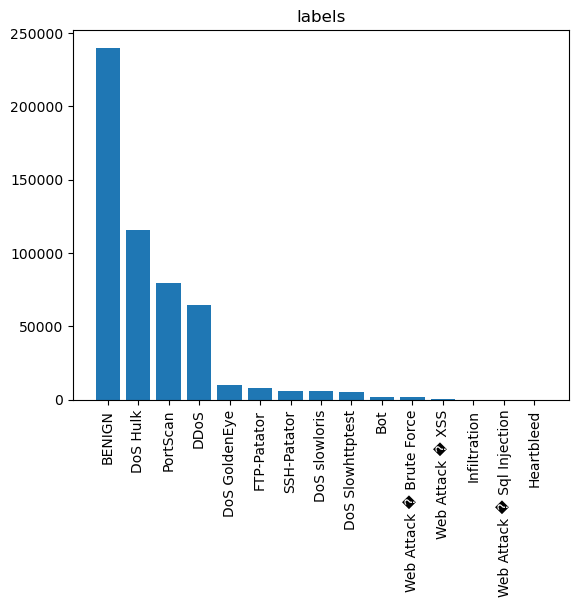

In [15]:
labels = df['label'].value_counts().index
counts = df['label'].value_counts().values


plt.bar(labels, counts)
plt.tick_params(axis='x', labelrotation = 90)
plt.title('labels')
plt.show()

### Проверка данных на мультиколлинеарность <a id='1.3'></a>

In [16]:
# Создадим датасет с данными корреляционного анализа

df_corr = df.drop('label', axis=1)
df_corr = df_corr.corr(numeric_only=True)

In [17]:
df_corr.head(3)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
destination_port,1.000000,-0.179121,-0.004491,-0.003684,0.011943,-0.002828,0.085761,-0.008278,0.125459,0.108413,...,-0.003234,0.000855,-0.044212,-0.032972,-0.049732,-0.035651,-0.158890,-0.025703,-0.159201,-0.155937
flow_duration,-0.179121,1.000000,0.018046,0.015152,0.052678,0.012175,0.253809,-0.090833,0.127411,0.240087,...,0.012132,-0.001428,0.191943,0.186125,0.242334,0.137895,0.883483,0.272722,0.902281,0.849129
total_fwd_packets,-0.004491,0.018046,1.000000,0.999204,0.228154,0.998667,0.012555,-0.002313,0.002589,0.004294,...,0.809370,-0.000011,0.014050,0.013113,0.017742,0.010058,0.003286,0.001856,0.003522,0.002994


In [18]:
# Создадим словарь со значениями параметров, имеющих высокую взамимную корреляцию
corr_max = 0.8
corr_min = -0.8
corr_diht = {}

for i in range(len(df_corr.columns)):
    a = df_corr.loc[(df_corr[df_corr.columns[i]]!=1)&(df_corr[df_corr.columns[i]]!=-1)&
            ((df_corr[df_corr.columns[i]]>corr_max)|(df_corr[df_corr.columns[i]]<corr_min)), 
            df_corr.columns[i]]
    if len(a) != 0:
        corr_diht[df_corr.columns[i]] = list(a.index)


In [19]:
# Визуализируем мультиколлинеарность
df_multicorr = pd.DataFrame.from_dict(corr_diht, orient='index')
df_multicorr

,0,1,2,3,4,5,6,7
flow_duration,flow_iat_std,flow_iat_max,fwd_iat_total,fwd_iat_std,fwd_iat_max,idle_mean,idle_max,idle_min
total_fwd_packets,total_backward_packets,total_length_of_bwd_packets,subflow_bwd_packets,subflow_bwd_bytes,act_data_pkt_fwd,None,None,None
total_backward_packets,total_fwd_packets,total_length_of_bwd_packets,subflow_fwd_packets,subflow_bwd_bytes,act_data_pkt_fwd,None,None,None
total_length_of_bwd_packets,total_fwd_packets,total_backward_packets,subflow_fwd_packets,subflow_bwd_packets,subflow_bwd_bytes,act_data_pkt_fwd,None,None
fwd_packet_length_max,fwd_packet_length_mean,fwd_packet_length_std,avg_fwd_segment_size,None,None,None,None,None
fwd_packet_length_mean,fwd_packet_length_max,fwd_packet_length_std,None,None,None,None,None,None
fwd_packet_length_std,fwd_packet_length_max,fwd_packet_length_mean,avg_fwd_segment_size,None,None,None,None,None
bwd_packet_length_max,bwd_packet_length_mean,bwd_packet_length_std,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,average_packet_size,avg_bwd_segment_size
bwd_packet_length_mean,bwd_packet_length_max,bwd_packet_length_std,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,average_packet_size,None
bwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_mean,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,average_packet_size,avg_bwd_segment_size


In [20]:
# Составим список столбцов, вызывающих мультиколлинеарность
# Список ключей
corr_list_key = list(corr_diht)

# Список столбцов, вызывающих мультиколлинеарность
multicorr_list = []
for i in corr_list_key:
    if i not in multicorr_list:
        multicorr_list += corr_diht[i]

### Проверка данных на бесконечность <a id='1.4'></a>

In [21]:
inf_plus = []
inf_minus = []

for i in df.columns:
    inf_plus.append(df.loc[df[i]==float('inf'), i].count())
    inf_minus.append(df.loc[df[i]==float('-inf'), i].count())
    
df_inf_class = pd.DataFrame({
    'params':df.columns, 
    'inf_plus':inf_plus,
    'inf_minus':inf_minus
})

df_inf_class.head(3)

,params,inf_plus,inf_minus
0,destination_port,0,0
1,flow_duration,0,0
2,total_fwd_packets,0,0


In [22]:
df_inf_class.loc[df_inf_class['inf_plus']!=0]

,params,inf_plus,inf_minus
14,flow_bytes_s,246,0
15,flow_packets_s,734,0


In [23]:
df_inf_class.loc[df_inf_class['inf_minus']!=0]

,params,inf_plus,inf_minus


### Общие выводы по качеству имеющихся данных <a id='1.5'></a>

Датасет содержит **79** столбцов и **539 616** строк. Общее число пропусков **488**.

Признаки есть как числовые, так и категориальные. Ряд признаков имеют одно или два значения. **8 признаков** с одним значением лишены смысла для целей обучения модели. Кроме того, есть **10 признаков** с двумя значениями. У четырех из них классы не сбалансированы и также не имеют смысла для целей обучения модели.

Целевой признак не сбалансирован. Есть четыре вида вредоносного трафика, детектирование которого будет осложнятся их редкостью.

Проверка на мультиколлинеарность выявила **41 признак**, имеющих взаимную корреляцию.

Два признака имеют значение бесконечность (`inf`). Наиболее оптимальным решением будет заменить их на максимальное значение.


## Подготовка данных <a id='2'></a>

### Предобработка данных <a id='2.1'></a>

**План по предобработке данных**

- Удалить явные дубликаты
- Удалить 8 признаков, содержащим одно значение, и 4 признака, содержащих два значения, при наличии выраженного дисбаланса
- Удалить 41 признак, вызывающий мультиколлинеарность
- Преобразовать нечисловые метки целевого признака в числовые
- Разделить датасет на обучающую и тестовую выборки 
- Заполнить пропуски медианными значениями
- Значения бесконечности заполнить максимальными значениями признака
- Провести стандартизацию признаков

In [24]:
# Удалим явные дубликаты
df = df.drop_duplicates().reset_index(drop=True)
print('Количество явных дублей - ', df.duplicated().sum())

Количество явных дублей -  0


In [25]:
df.shape

(475015, 79)

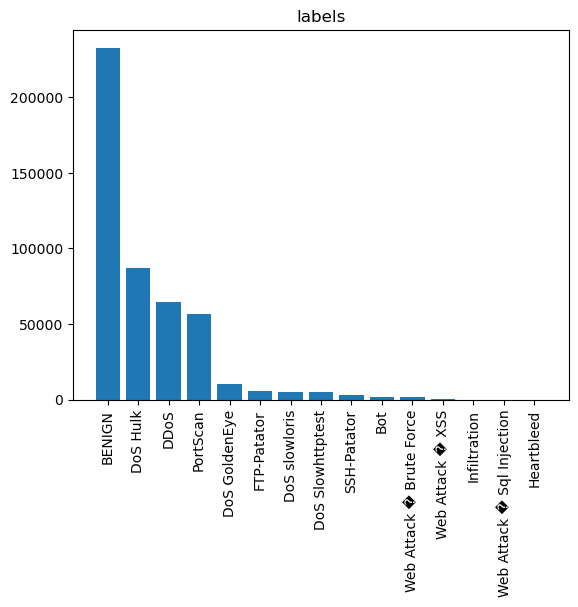

In [26]:
# Проверим наличие всех классов
labels = df['label'].value_counts().index
counts = df['label'].value_counts().values

plt.bar(labels, counts)
plt.tick_params(axis='x', labelrotation = 90)
plt.title('labels')
plt.show()

In [27]:
# Сформируем список столбцов, для удаления
drop_list = multicorr_list + train_1_class + train_2_class_short
drop_list = list(set(drop_list))

# Удалим столбцы
df.drop(drop_list, axis=1, inplace=True)

In [28]:
# Преобразуем нечисловые метки таргета в числовые 
le = LabelEncoder()
le.fit(list(df['label'].unique()))

df['label_le'] = le.transform(df['label'])

In [29]:
df.shape

(475015, 36)

In [30]:
# Разделим датасет на признаки и целевые результаты
features = df.drop(['label', 'label_le'], axis=1)
target = df['label_le']

In [31]:
# Разделим на обучающую и тестовую выборки
# Разделим данные на обучающую и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=.2,                                                                            
                                                                            random_state=state)
print(f'Обучающая выборка признаков - {features_train.shape}')
print(f'Обучающая выборка целевого признака - {target_train.shape}')
print(f'Тестовая выборка признаков - {features_test.shape}')
print(f'Тестовая выборка целевого признака - {target_test.shape}')

Обучающая выборка признаков - (380012, 34)
Обучающая выборка целевого признака - (380012,)
Тестовая выборка признаков - (95003, 34)
Тестовая выборка целевого признака - (95003,)


In [32]:
# Баланс классов в обучающей выборке
target_train.value_counts()

label_le
0     186098
4      69764
2      51515
10     45083
3       8318
7       4700
6       4362
5       4216
11      2625
1       1583
12      1169
14       529
9         30
13        12
8          8
Name: count, dtype: int64

In [33]:
# Баланс классов в тестовой выборке
target_test.value_counts()

label_le
0     46711
4     17487
2     12849
10    11314
3      1968
7      1233
6      1023
5      1012
11      594
1       370
12      301
14      123
13        9
9         6
8         3
Name: count, dtype: int64

In [34]:
# Заполним пропуски медианным значениеи в обучающей и тестовой выборке

print('Пропусков в обучающей выборке')
print(features_train.isna().sum())
print()
print('Пропусков в тестовой выборке')
print(features_test.isna().sum())


Пропусков в обучающей выборке
destination_port                0
flow_duration                   0
total_fwd_packets               0
total_length_of_fwd_packets     0
fwd_packet_length_max           0
fwd_packet_length_min           0
bwd_packet_length_max           0
bwd_packet_length_min           0
flow_bytes_s                   34
flow_packets_s                  0
flow_iat_mean                   0
flow_iat_min                    0
fwd_iat_min                     0
bwd_iat_total                   0
bwd_iat_mean                    0
bwd_iat_std                     0
fwd_psh_flags                   0
fwd_header_length               0
bwd_packets_s                   0
min_packet_length               0
fin_flag_count                  0
syn_flag_count                  0
psh_flag_count                  0
ack_flag_count                  0
urg_flag_count                  0
down_up_ratio                   0
fwd_header_length_1             0
subflow_fwd_packets             0
subflow_fwd_bytes 

In [35]:
features_train['flow_bytes_s'] = features_train['flow_bytes_s'].fillna(features_train['flow_bytes_s'].median())
features_test['flow_bytes_s'] = features_test['flow_bytes_s'].fillna(features_test['flow_bytes_s'].median())

In [36]:
print('Пропусков в обучающей выборке ', features_train.isna().sum().sum())
print('Пропусков в тестовой выборке ', features_test.isna().sum().sum())


Пропусков в обучающей выборке  0
Пропусков в тестовой выборке  0


**Обработка бесконечности**

In [37]:
# Определим размер данных с бесконечностью
print('features_train')
for i in ['flow_bytes_s', 'flow_packets_s']:
    print('inf ', i, features_train.loc[features_train[i]==float('inf'), i].count())
    print('-inf ', i, features_train.loc[features_train[i]==float('-inf'), i].count())

print('features_test')
for i in ['flow_bytes_s', 'flow_packets_s']:
    print('inf ', i, features_test.loc[features_test[i]==float('inf'), i].count())
    print('-inf ', i, features_test.loc[features_test[i]==float('-inf'), i].count())

features_train
inf  flow_bytes_s 165
-inf  flow_bytes_s 0
inf  flow_packets_s 199
-inf  flow_packets_s 0
features_test
inf  flow_bytes_s 57
-inf  flow_bytes_s 0
inf  flow_packets_s 63
-inf  flow_packets_s 0


In [38]:
for i in ['flow_bytes_s', 'flow_packets_s']:
    a = list(features_train[i])
    M = max(a)
    mm = max(n for n in a if n!=M)
    features_train[i] = features_train[i].replace(float('inf'), mm)

for i in ['flow_bytes_s', 'flow_packets_s']:
    a = list(features_test[i])
    M = max(a)
    mm = max(n for n in a if n!=M)
    features_test[i] = features_test[i].replace(float('inf'), mm)


In [39]:
# Определим размер данных с бесконечностью
print('features_train')
for i in ['flow_bytes_s', 'flow_packets_s']:
    print('inf ', i, features_train.loc[features_train[i]==float('inf'), i].count())
    print('-inf ', i, features_train.loc[features_train[i]==float('-inf'), i].count())

print('features_test')
for i in ['flow_bytes_s', 'flow_packets_s']:
    print('inf ', i, features_test.loc[features_test[i]==float('inf'), i].count())
    print('-inf ', i, features_test.loc[features_test[i]==float('-inf'), i].count())

features_train
inf  flow_bytes_s 0
-inf  flow_bytes_s 0
inf  flow_packets_s 0
-inf  flow_packets_s 0
features_test
inf  flow_bytes_s 0
-inf  flow_bytes_s 0
inf  flow_packets_s 0
-inf  flow_packets_s 0


In [40]:
# Проведем стандартизацию данных

scaler = StandardScaler()
scaler.fit(features_train)
features_train_skaled = scaler.transform(features_train)
features_test_skaled = scaler.transform(features_test)

print(f'Обучающая стандартизированная выборка признаков - {features_train_skaled.shape}')
print(f'Тестовая стандартизированная выборка признаков - {features_test_skaled.shape}')

Обучающая стандартизированная выборка признаков - (380012, 34)
Тестовая стандартизированная выборка признаков - (95003, 34)


### Общие выводы по подготовке данных <a id='2.2'></a>

Сформирован сбалансированный набор показателей для эффективного детектирования вредоносного трафика.

Удалены явные дубликаты, заполнены пропуски данных и заменены значения бесконечности. Снижение уровня мультиколлинеарности достигнуто удалением 41 параметра. Также удалены параметры, имеющие одно значение или два несбалансированных значения. Все признаки стандартизированы, а целевой признак преобразован в числовой.


## Обучение моделей <a id='3'></a>

**План по обучению моделей**

- Обучить модель методом `Логистической регрессии`
- Обучить модель методом `Решающего дерева` с подбором параметров методом `GridSearchCV`
- Обучить модель методом `Случайного леса` с подбором параметров методом `GridSearchCV`
- Обучить модель методом с использованием Фреймворка `LightGBM`


In [41]:
target_names = list(df['label'].unique())

Обучение методом `Регрессии`

In [42]:
%%time

model_regr = LogisticRegression()
model_regr.fit(features_train_skaled, target_train)

answer_regr = model_regr.predict(features_test_skaled)
f1_model_regr = f1_score(target_test, answer_regr, average='micro')

print(f'f1_score на регрессии - {f1_model_regr:.4f}')
print()
print(classification_report(target_test, answer_regr, target_names=target_names, zero_division = 0))

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1_score на регрессии - 0.9524

                            precision    recall  f1-score   support

                    BENIGN       0.96      0.95      0.95     46711
                  PortScan       0.50      0.00      0.01       370
                  DoS Hulk       0.98      1.00      0.99     12849
                      DDoS       0.93      0.88      0.91      1968
                       Bot       0.95      0.99      0.97     17487
              Infiltration       0.90      0.84      0.87      1012
  Web Attack � Brute Force       0.85      0.88      0.87      1023
          Web Attack � XSS       0.88      0.99      0.93      1233
Web Attack � Sql Injection       1.00      0.67      0.80         3
               FTP-Patator       0.75      0.50      0.60         6
               SSH-Patator       0.93      0.99      0.96     11314
             DoS slowloris       0.00      0.00      0.00       594
          DoS Slowhttptest       0.59      0.04      0.08       301
             Do

Обучение методом `Решающего дерева`

In [43]:
%%time

# Подберем лучшие параметры Решающего дерева методом GridSearchCV
clf = DecisionTreeClassifier(random_state=state)
parametrs = {'max_depth': range(10, 31, 10)}

model_tree_cv = GridSearchCV(clf, parametrs, cv=5)
model_tree_cv.fit(features_train_skaled, target_train)
best_depth_tree = model_tree_cv.best_params_.get('max_depth')

print(f'Лучший параметр глубины - {best_depth_tree}')

# Обучим и проверим модель с подобранными параметрами
model_tree = DecisionTreeClassifier(max_depth=best_depth_tree, random_state=state)
model_tree.fit(features_train_skaled, target_train)
answer_tree = model_tree.predict(features_test_skaled)
f1_model_tree = f1_score(target_test, answer_tree, average='micro')

print(f'Решающее дерево с глубиной {best_depth_tree} достигает значение метрики F1 {f1_model_tree:.4f}')
print()
print(classification_report(target_test, answer_tree, target_names=target_names, zero_division = 0))


Лучший параметр глубины - 20
Решающее дерево с глубиной 20 достигает значение метрики F1 0.9968

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     46711
                  PortScan       0.96      0.94      0.95       370
                  DoS Hulk       1.00      1.00      1.00     12849
                      DDoS       1.00      1.00      1.00      1968
                       Bot       1.00      1.00      1.00     17487
              Infiltration       0.99      1.00      0.99      1012
  Web Attack � Brute Force       1.00      0.99      0.99      1023
          Web Attack � XSS       1.00      1.00      1.00      1233
Web Attack � Sql Injection       1.00      0.67      0.80         3
               FTP-Patator       0.83      0.83      0.83         6
               SSH-Patator       1.00      1.00      1.00     11314
             DoS slowloris       1.00      1.00      1.00       594
          DoS Slow

Обучение методом `Случайного леса`

In [44]:
%%time

# Подберем лучшие параметры Случайного леса методом GridSearchCV
clf = RandomForestClassifier(max_depth=best_depth_tree, random_state=state)
parametrs = {'n_estimators': range(30, 91, 30)}

model_forest_cv = GridSearchCV(clf, parametrs, cv=5)
model_forest_cv.fit(features_train_skaled, target_train)
best_est_forest = model_forest_cv.best_params_.get('n_estimators')

print(f'Лучший параметр числа деревьев - {best_est_forest}')

# Обучим и проверим модель с подобранными параметрами
model_forest = RandomForestClassifier(max_depth=best_depth_tree, n_estimators=best_est_forest, random_state=state)
model_forest.fit(features_train_skaled, target_train)
answer_forest = model_forest.predict(features_test_skaled)
f1_model_forest = f1_score(target_test, answer_forest, average='micro')

print(f'случайный лес с числом деревьев {best_est_forest} достигает значение метрики F1 {f1_model_forest:.4f}')
print()
print(classification_report(target_test, answer_forest, target_names=target_names, zero_division = 0))


Лучший параметр числа деревьев - 90
случайный лес с числом деревьев 90 достигает значение метрики F1 0.9976

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     46711
                  PortScan       0.96      0.95      0.95       370
                  DoS Hulk       1.00      1.00      1.00     12849
                      DDoS       1.00      1.00      1.00      1968
                       Bot       1.00      1.00      1.00     17487
              Infiltration       1.00      1.00      1.00      1012
  Web Attack � Brute Force       1.00      1.00      1.00      1023
          Web Attack � XSS       1.00      1.00      1.00      1233
Web Attack � Sql Injection       1.00      1.00      1.00         3
               FTP-Patator       1.00      0.83      0.91         6
               SSH-Patator       1.00      1.00      1.00     11314
             DoS slowloris       1.00      1.00      1.00       594
      

Обучение с использованием Фреймворка `LightGBM`

In [45]:
%%time
# Создадим модель с использованием Фреймворка LightGBM

model_lgb = lgb.LGBMClassifier(objective="multiclassova", n_estimators=10, num_class=15)
model_lgb.fit(features_train_skaled, target_train, eval_set=[(features_test_skaled, target_test),])

answerr_model_lgb = model_lgb.predict(features_test_skaled)
f1_model_lgb = f1_score(target_test, answerr_model_lgb, average='micro')

print(f'lgb достигает значение метрики F1 {f1_model_lgb:.4f}')
print()
print(classification_report(target_test, answerr_model_lgb, target_names=target_names, zero_division = 0))

[1]	valid_0's multi_logloss: 0.917027
[2]	valid_0's multi_logloss: 0.891418
[3]	valid_0's multi_logloss: 0.718018
[4]	valid_0's multi_logloss: 0.587892
[5]	valid_0's multi_logloss: 0.580076
[6]	valid_0's multi_logloss: 0.484275
[7]	valid_0's multi_logloss: 0.41119
[8]	valid_0's multi_logloss: 0.371882
[9]	valid_0's multi_logloss: 0.331989
[10]	valid_0's multi_logloss: 0.305643
lgb достигает значение метрики F1 0.9953

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     46711
                  PortScan       0.92      0.95      0.93       370
                  DoS Hulk       1.00      1.00      1.00     12849
                      DDoS       1.00      0.99      0.99      1968
                       Bot       1.00      1.00      1.00     17487
              Infiltration       1.00      0.99      0.99      1012
  Web Attack � Brute Force       1.00      0.99      0.99      1023
          Web Attack � XSS       

### Общие выводы <a id='3.1'></a>

Для решения задачи выявления вредоносного трафика было применено четыре метода:

- модель `Логистической регрессии`
- модель `Решающего дерева`
- модель `Случайного леса`
- модель `LightGBM`

Для улучшения качества моделей `Решающего дерева` и `Случайного леса` применен подбор параметров методом `GridSearchCV`.

Важно было не только достичь максимального значения общего показателя `f1_score` по всем классам, но и обеспечить корректное детектирование несбалансированных классов.

`Логистическая регрессия` показала как наихудшее значение общего показателя `f1_score` - **0.9524**, так и плохой уровень детектирования несбалансированных классов (**0.8, 0.6, 0.0**). Время обучения модели составило **33 с.**

Модель с использованием Фреймворка `LightGBM` при параметре **числа оценщиков 10**, показала хороший уровень значения общего показателя `f1_score` - **0.9953**, при низком уровне детектирования несбалансированных классов (**0.0, 0.07, 0.06**). Время обучения модели составило **23 с.**

Модель `Решающего дерева` с параметром **глубины 20**, показала хороший уровень значения общего показателя `f1_score` - **0.9968**, при хорошем уровне детектирования несбалансированных классов (**0.8, 0.83, 0.44**). Негативной стороной является долгое обучение модели, которое составило **2 мин 51 с.**

Модель `Случайного леса` с параметром **числа деревьев 90**, показала наивысший уровень значения общего показателя `f1_score` - **0.9976**, при очень хорошем уровне детектирования несбалансированных классов (**1.0, 0.91, 0.71**). Негативной стороной является крайне долгое обучение модели, которое составило **28 мин 25 с.**

Таким образом, наилучший результата показала модель `Случайного леса` с **глубиной 20** и **числом деревьев 90**. Значение общего показателя `f1_score` - **0.9976**, при уровне детектирования несбалансированных классов **1.0, 0.91, 0.71**.

